In [1]:
# Part of this code is based on a PyTorch tutorial found here: 
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Many alterations and important additions have been made for the goal of this thesis by its author
# Author: Konstantinos Papadopoulos

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchtext.vocab as vocab

# switch between CPU and CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from __future__ import print_function

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import nltk
from config import fit_text

In [3]:
# read csv file
df = pd.read_csv('fake_or_real_news.csv') 

In [4]:
np.random.seed(10)
df.title = 'sos ' + df.title + ' eos'

Y = df.title
X = df['text']

# split data into random train and test subsets (20% for testing, 80% for training)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [5]:
config = fit_text(X, Y)

In [6]:
config['target_word2idx']['republicans']
config['target_idx2word'][79]

u'republicans'

# Use GloVe for training

In [7]:
class NewVocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        # how many times a word appears
        self.word2count = {}
        self.index2word = {}
        # index
        self.n_words = 0  

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [8]:
input_vocab = NewVocab('input')
input_vocab.word2index = config['input_word2idx']
input_vocab.index2word = config['input_idx2word']
input_vocab.n_words = config['num_input_tokens']

In [9]:
output_vocab = NewVocab('output')
output_vocab.word2index = config['target_word2idx']
output_vocab.index2word = config['target_idx2word']
output_vocab.n_words = config['num_target_tokens']

In [10]:
glove = vocab.GloVe(name='6B', dim=300) # I selected 100 dimensional array

print('Loaded {} words'.format(len(glove.itos))) # itos = index-to-string
# returns the 300 dimensional embedding 
def get_word(word):
    return glove.vectors[glove.stoi[word]].to(device) # stoi = string-to-index

get_word('hello')

tensor([-0.3371, -0.2169, -0.0066, -0.4162, -1.2555, -0.0285, -0.7219, -0.5289,
         0.0072,  0.3200,  0.0294, -0.0132,  0.4351,  0.2572,  0.3900, -0.1197,
         0.1504,  0.4476,  0.2841,  0.4934,  0.6283,  0.2289, -0.4038,  0.0274,
         0.0074,  0.1400,  0.2335,  0.0681,  0.4842, -0.0196, -0.5475, -0.5498,
        -0.0341,  0.0080, -0.4306, -0.0190, -0.0857, -0.8112, -0.2108,  0.3778,
        -0.3505,  0.1368, -0.5566,  0.1683, -0.2295, -0.1618,  0.6734, -0.4660,
        -0.0318, -0.2604, -0.1780,  0.0194,  0.1073,  0.6653, -0.3484,  0.0478,
         0.1644,  0.1409,  0.1920, -0.3501,  0.2624,  0.1763, -0.3137,  0.1171,
         0.2038,  0.6177,  0.4908, -0.0752, -0.1182,  0.1868,  0.4068,  0.2832,
        -0.1629,  0.0384,  0.4379,  0.0882,  0.5905, -0.0535,  0.0388,  0.1820,
        -0.2760,  0.3947, -0.2050,  0.1741,  0.1032,  0.2512, -0.3654,  0.3653,
         0.2245, -0.9755,  0.0945, -0.1786, -0.3069, -0.5863, -0.1853,  0.0396,
        -0.4231, -0.1572,  0.2040,  0.16

In [11]:
from torch.autograd import Variable

matrix_len = input_vocab.n_words
weights_matrix = Variable(torch.Tensor(np.zeros((matrix_len, glove.dim))))
words_found = 0

for i, word in enumerate(input_vocab.index2word):
    try: 
        weights_matrix[i] = Variable(torch.Tensor(glove[input_vocab.index2word[i]]))
        words_found += 12
    except KeyError:
        weights_matrix[i] = Variable(torch.Tensor(np.random.normal(scale=0.6, size=(emb_dim, ))))

In [12]:
matrix_len = output_vocab.n_words
output_weights_matrix = Variable(torch.Tensor(np.zeros((matrix_len, glove.dim))))
words_found = 0

for i, word in enumerate(output_vocab.index2word):
    try: 
        output_weights_matrix[i] = Variable(torch.Tensor(glove[output_vocab.index2word[i]]))
        words_found += 1
    except KeyError:
        output_weights_matrix[i] = Variable(torch.Tensor(np.random.normal(scale=0.6, size=(emb_dim, ))))

In [13]:
#PAD_token = 0
SOS_token = 1
EOS_token = 2

# Preparing train-test data

In [14]:
#####################################################################
# The files are all in Unicode, to simplify we will turn Unicode
# characters to ASCII, make everything lowercase, and trim most
# punctuation.

# Turn a Unicode string to plain ASCII, thanks to:
# http://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s.decode('latin1'))
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
tokenizer.PUNCTUATION = [
        (re.compile(r'([:,])([^\d])'), r' \1 \2'),
        (re.compile(r'([:,])$'), r' \1 '),
        (re.compile(r'\.\.\.'), r' ... '),
        (re.compile(r'\#\#\#\#'), r' #### '),
        (re.compile(r'[;@$%&]'), r' \g<0> '),
        (re.compile(r'([^\.])(\.)([\]\)}>"\']*)\s*$'), r'\1 \2\3 '),  # Handles the final period.
        (re.compile(r'[?!]'), r' \g<0> '),

        (re.compile(r"([^'])' "), r"\1 ' "),
    ]


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r'\[[^)]*\]', '', s)
    s = re.sub('\d',  r'#', s)
    s = re.sub("’|‘|”|“|``",  r"'", s)
    #s = re.sub(r"([.!?:&#'])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?:&#']+", r" ", s)
    s = tokenizer.tokenize(text=s)
    return s

In [15]:
X_norm_train = [normalizeString(train) for train in X_train]
X_norm_test = [normalizeString(test) for test in X_test]
Y_norm_train = [normalizeString(train) for train in Y_train]
Y_norm_test = [normalizeString(test) for test in Y_test]

In [16]:
MAX_INPUT_LENGTH = 50
MAX_OUTPUT_LENGTH = 50

In [17]:
X_filter_train = [train[:MAX_INPUT_LENGTH] for train in X_norm_train]
X_filter_test = [test[:MAX_INPUT_LENGTH] for test in X_norm_test]
Y_filter_train = [train[:MAX_OUTPUT_LENGTH] for train in Y_norm_train]
Y_filter_test = [test[:MAX_OUTPUT_LENGTH] for test in Y_norm_test]

In [18]:
input_vocab.n_words

10002

In [19]:
output_vocab.n_words

5001

In [20]:
def indexesFromSample(vocab, sample):
    #vocab.word2index[word]
    #return [glove.stoi[word] if (word in glove.stoi) else (glove.stoi['unk']) for word in sample.split(' ')]
    #print([vocab.word2index[word] if (word in vocab.word2index) else vocab.word2index['UNK'] for word in sample])
    return [vocab.word2index[word] for word in sample if word in vocab.word2index]

def tensorFromSample(vocab, sample):
    indexes = indexesFromSample(vocab, sample)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSample(input_vocab, pair[0])
    target_tensor = tensorFromSample(output_vocab, pair[1])
    return (input_tensor, target_tensor)

In [21]:
train_pairs = [[x,y] for x, y in zip(X_filter_train, Y_filter_train)]
test_pairs = [[x,y] for x, y in zip(X_filter_test, Y_filter_test)]

# Option #1 for Seq2Seq model: Unidirectional RNN with GRU

In [22]:
#####################################################################
# The Seq2Seq Model
# Encoder
# ^^^^^^^^^^^^^^^^^


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # input_size = number of words in vocab, e.g., 400000
        # hidden_size = dimension of embedding, e.g., 100
        self.hidden_size = hidden_size
        # stores embeddings of the dictionary 
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        self.embedding.load_state_dict({'weight': weights_matrix})
        self.embedding.weight.requires_grad = False
        # applies a Gated Recurrent Unit (GRU) RNN
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        #output = self.conv1d(output)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
#####################################################################
# Attention Decoder
# ^^^^^^^^^^^^^^^^^

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5, max_length=MAX_INPUT_LENGTH+1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding.load_state_dict({'weight': output_weights_matrix})
        self.embedding.weight.requires_grad = False
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # bmm = batched matrix multiplication
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        #print(output.shape, hidden.shape)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

########################## END OF OPTION 1 ##########################
#####################################################################

# Option #2 for Seq2Seq model: Bidirectional RNN with LSTM

In [22]:
#####################################################################
# The Seq2Seq Model
# Encoder
# ^^^^^^^^^^^^^^^^^


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        #input_size = number of words in vocab, e.g., 400000
        #hidden_size = dimension of embedding, e.g., 100
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding.load_state_dict({'weight': weights_matrix})
        self.embedding.weight.requires_grad = True
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        output, hidden = self.bilstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.randn(2, 1, self.hidden_size//2, device=device),
                torch.randn(2, 1, self.hidden_size//2, device=device))

In [23]:
#####################################################################
# Attention Decoder
# ^^^^^^^^^^^^^^^^^


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5, max_length=MAX_OUTPUT_LENGTH+1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding.load_state_dict({'weight': output_weights_matrix})
        self.embedding.weight.requires_grad = True
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length, )
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.bilstm = nn.LSTM(self.hidden_size, self.hidden_size//2, bidirectional=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #print(embedded[0].size(), hidden[0].unsqueeze(0).size())

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0].view(1, -1)), 1)), dim=1)
        
        # bmm = batched matrix multiplication
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        
        output, hidden = self.bilstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.randn(2, 1, self.hidden_size//2, device=device),
                torch.randn(2, 1, self.hidden_size//2, device=device))
    

########################## END OF OPTION 2 ##########################
#####################################################################

# Beam Search (additional option for the decoder)

In [24]:
def beam_search(decoder,decoder_input, decoder_hidden, encoder_outputs, iters = 20, k = 3):
    sequences = [[list(), 0.0]]
    
    # walk over each step in sequence
    for d in range(iters):
        #print('sequences',sequences)

        all_candidates = list()
        # expand each current candidate
        #print(encoder_outputs)

        for i in range(len(sequences)):
            #print(sequences)
            seq, log_probs = sequences[i]
            if d >0:
                decoder_input = seq[-1]
            if decoder_input.item() == EOS_token:
                continue
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(k)
            
            #decoded_words.append(input_text.index2word[topi.item()]) #glove.itos
                #input_text.index2word

            #decoder_input = topi.squeeze().detach()
            #print(topv)
            for j in range(k):
                #print(topv[0][j])
                candidate = [seq + [topi[0][j]], log_probs + (topv[0][j])]
                #print('candidate', candidate)
                all_candidates.append(candidate)
                
            # order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:-tup[1])
            #print(ordered)
            # select k best
            sequences = ordered[:k]
    #print(sequences)    
    return sequences

In [25]:
######################################################################
# Beam search evaluation
# ^^^^^^^^^^^^^^^^^^^^^^


def beam_evaluate(encoder, decoder, sentence, max_length=MAX_INPUT_LENGTH+1):
    with torch.no_grad():
        input_tensor = tensorFromSample(input_vocab, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        best = beam_search(decoder,decoder_input, decoder_hidden, encoder_outputs, 15, 3)
        
        for i in best[0][0]:
            decoded_words.append(output_vocab.index2word[i.item()])

        return decoded_words#, decoder_attentions[:di + 1]

# Training

In [24]:
teacher_forcing_ratio = 0.2

def train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,max_length=MAX_INPUT_LENGTH+1):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    #print(input_tensor.size())

    #if input_length>20
    for ei in range(input_length):
        #print(ei)
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    
    else:   
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [25]:
#####################################################################
# This is a helper function to print time elapsed and estimated time
# remaining given the current time and progress %.

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=1000, learning_rate=0.001, reduce = 10000*6):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad,encoder.parameters()), lr=learning_rate)
    decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad,decoder.parameters()), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs)) for i in range(n_iters)]#,size=64
    
    #print(training_pairs[0],training_pairs[1])
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #print(input_tensor)
        #print(target_tensor)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % reduce == 0:
            learning_rate /= 2
            print('lr was reduced to: ', learning_rate)
            encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad,encoder.parameters()), lr=learning_rate)
            decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad,decoder.parameters()), lr=learning_rate)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Plotting

In [27]:
#####################################################################
# Plotting results
# ^^^^^^^^^^^^^^^^
#
# Plotting is done with matplotlib, using the array of loss values
# ``plot_losses`` saved while training.

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation 

In [33]:
#####################################################################
# Evaluation
# ^^^^^^^^^^

def evaluate(encoder, decoder, sentence, max_length=MAX_INPUT_LENGTH+1):
    with torch.no_grad():
        input_tensor = tensorFromSample(input_vocab, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        #best = beam_search(decoder,decoder_input, decoder_hidden, encoder_outputs,20,30)
        
        for di in range(25):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs) 
            
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                if (di)<14:
                    pass
                decoded_words.append('eos')
                break
            else:
                decoded_words.append(output_vocab.index2word[topi.item()]) #glove.itos
                
            #input_text.index2word

            decoder_input = topi.squeeze().detach()
             
            #decoded_words.append(input_text.index2word[i.item()])
        return decoded_words#, decoder_attentions[:di + 1]

In [34]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', ' '.join(pair[0]))
        print('=', ' '.join(pair[1]))
        output_words = evaluate(encoder, decoder, pair[0])#, attentions
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Start training

In [30]:
hidden_size = 300 #glove.dim
encoder1 = EncoderRNN(input_vocab.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_vocab.n_words, dropout_p=0.1).to(device)

<Figure size 432x288 with 0 Axes>

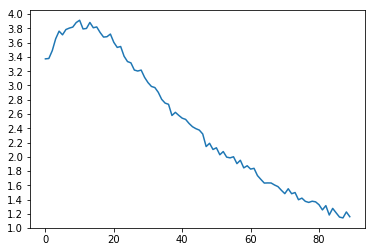

In [31]:
trainIters(encoder1, attn_decoder1, 10000*3*3, print_every=1000, learning_rate=0.001, reduce=10000*3)

In [38]:
evaluateRandomly(encoder1, attn_decoder1, train_pairs)

# Rouge-1 precision recall score

In [39]:
def rouge(evaluate):
    precisions = []
    recalls = []
    scores = []
    for pair in test_pairs:
        candidate  = evaluate(encoder1, attn_decoder1, pair[0])#, attentions
        #reference_p = pair[1].copy()
        #reference_r = pair[1].copy()

        reference_p = list(pair[1])
        reference_r = list(pair[1])
        
        count_p = 0.0
        count_r = 0.0

        for i in candidate[1:-1]:
            if i in reference_p[1:-1]:
                count_p+=1.00
                reference_p.remove(i)
        if len(candidate[1:-1])>0:
            precision = count_p/len(candidate[1:-1]) #precision
            precisions.append(precision) 

        for j in reference_r[1:-1]:
            if j in candidate[1:-1]:
                count_r+=1.00  

        recall = count_r/len(reference_r[1:-1]) #recall
        recalls.append(recall) 
    return precisions, recalls

# Evaluating without Beam Search

In [40]:
precisions, recalls = rouge(evaluate)

In [41]:
pr = np.mean(np.asarray(precisions))
print(pr)
rec = np.mean(np.asarray(recalls))
print(rec)

In [42]:
score = pr*rec*2/(pr+rec)
score

0.07852052556381142

# Evaluating Beam Search

In [37]:
precisions, recalls = rouge(beam_evaluate)
pr = np.mean(np.asarray(precisions))
print(pr)
rec = np.mean(np.asarray(recalls))
print(rec)

score = pr*rec*2/(pr+rec)
score

0.099703657667497

# Visualising Attention

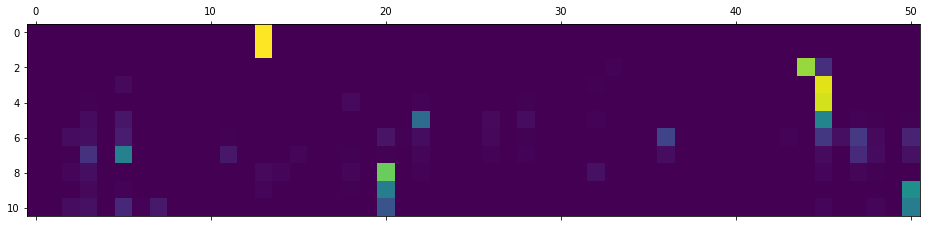

In [60]:
test_input = "sunday night's public proclamation that sen. ted cruz of texas and ohio gov. john kasich had reached a truce aimed at ceding states to one another was not predicted but also entirely predictable. with his failure to gain any delegates in new york, cruz is no longer able ."
test_input_norm = [normalizeString(test) for test in test_input]  
test_input_final = [test[:MAX_INPUT_LENGTH] for test in test_input_norm]

output_words, attentions = evaluate(encoder1, attn_decoder1, test_input)
plt.matshow(attentions.numpy())

In [79]:
def showAttention(input_text, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_text.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def evaluateAndShowAttention(input_text):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_text)
    print('input =', input_text)
    print('output =', ' '.join(output_words))
    showAttention(input_text, output_words, attentions)

In [ ]:
evaluateAndShowAttention(test_input)

# Save the model

In [ ]:
torch.save(encoder1.state_dict(), 'encoder.pth')
torch.save(attn_decoder1.state_dict(), 'attn_decoder.pth')

# Load the model

In [ ]:
encoder1.load_state_dict(torch.load('encoder.pth'))
attn_decoder1.load_state_dict(torch.load('attn_decoder.pth'))

# Model Summary

In [67]:
print(encoder1)

In [69]:
print(attn_decoder1)